In [1]:
%%time
import os
if not os.path.exists('CSRNet-pytorch/'):
    !pip install -U scipy torch_snippets torch_summary
    !git clone https://github.com/sizhky/CSRNet-pytorch.git
    from google.colab import files
    files.upload() # upload kaggle.json
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !ls ~/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json
    print('downloading data...')
    !kaggle datasets download -d tthien/shanghaitech-with-people-density-map/
    print('unzipping data...')
    !unzip -qq shanghaitech-with-people-density-map.zip

%cd CSRNet-pytorch
!ln -s ../shanghaitech_with_people_density_map
from torch_snippets import *
import h5py
from scipy import io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.9/172.9 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 33.0 MB/s eta 0:00:0

Cloning into 'CSRNet-pytorch'...
remote: Enumerating objects: 92, done.
remote: Total 92 (delta 0), reused 0 (delta 0), pack-reused 92
Receiving objects: 100% (92/92), 623.74 KiB | 2.02 MiB/s, done.
Resolving deltas: 100% (51/51), done.


Saving kaggle.json to kaggle.json
kaggle.json
downloading data...
100% 4.77G/4.79G [00:51<00:00, 52.8MB/s]
100% 4.79G/4.79G [00:51<00:00, 100MB/s] 
unzipping data...
/content/CSRNet-pytorch
CPU times: user 4.47 s, sys: 908 ms, total: 5.38 s
Wall time: 2min 58s


In [2]:
part_A = Glob('shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/');

image_folder = 'shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/images/'
heatmap_folder = 'shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/ground-truth-h5/'
gt_folder = 'shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/ground-truth/'

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tfm = T.Compose([
    T.ToTensor()
])

class Crowds(Dataset):
    def __init__(self, stems):
        self.stems = stems

    def __len__(self):
        return len(self.stems)

    def __getitem__(self, ix):
        _stem = self.stems[ix]
        image_path = f'{image_folder}/{_stem}.jpg'
        heatmap_path = f'{heatmap_folder}/{_stem}.h5'
        gt_path = f'{gt_folder}/GT_{_stem}.mat'

        pts = io.loadmat(gt_path)
        pts = len(pts['image_info'][0,0][0,0][0])

        image = read(image_path, 1)
        with h5py.File(heatmap_path, 'r') as hf:
            gt = hf['density'][:]
        gt = resize(gt, 1/8)*64
        return image.copy(), gt.copy(), pts

    def collate_fn(self, batch):
        ims, gts, pts = list(zip(*batch))
        ims = torch.cat([tfm(im)[None] for im in ims]).to(device)
        gts = torch.cat([tfm(gt)[None] for gt in gts]).to(device)
        return ims, gts, torch.tensor(pts).to(device)

    def choose(self):
        return self[randint(len(self))]

from sklearn.model_selection import train_test_split
trn_stems, val_stems = train_test_split(stems(Glob(image_folder)), random_state=10)

trn_ds = Crowds(trn_stems)
val_ds = Crowds(val_stems)

trn_dl = DataLoader(trn_ds, batch_size=1, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

In [5]:
import torch.nn as nn
import torch
from torchvision import models
from utils import save_net,load_net

def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate, dilation=d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [6]:
class CSRNet(nn.Module):
  def __init__(self, load_weights=False):
    super(CSRNet, self).__init__()
    self.seen = 0
    self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256,
                           256, 256, 'M', 512, 512, 512]
    self.backend_feat = [512, 512, 512, 256, 128, 64]
    self.frontend = make_layers(self.frontend_feat)
    self.backend = make_layers(self.backend_feat, in_channels=512, dilation=True)
    self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
    if not load_weights:
      mod = models.vgg16(pretrained=True)
      self._initialize_weights()
      items = list(self.frontend.state_dict().items())
      _items = list(mod.state_dict().items())
      for i in range(len(self.frontend.state_dict().items())):
        items[i][1].data[:] = _items[i][1].data[:]
  def forward(self, x):
    x = self.frontend(x)
    x = self.backend(x)
    x = self.output_layer(x)
    return x
  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight, std=0.01)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

In [7]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    ims, gts, pts = data
    _gts = model(ims)
    loss = criterion(_gts, gts)
    loss.backward()
    optimizer.step()
    pts_loss = nn.L1Loss()(_gts.sum(), gts.sum())
    return loss.item(), pts_loss.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, gts, pts = data
    _gts = model(ims)
    loss = criterion(_gts, gts)
    pts_loss = nn.L1Loss()(_gts.sum(), gts.sum())
    return loss.item(), pts_loss.item()

In [8]:
model = CSRNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)
n_epochs = 20

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, pts_loss = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_pts_loss=pts_loss, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, pts_loss = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_pts_loss=pts_loss, end='\r')

    log.report_avgs(ex+1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 206MB/s]


EPOCH: 1.000  trn_loss: 0.058  trn_pts_loss: 828.522  val_loss: 0.052  val_pts_loss: 323.537  (86.27s - 1639.11s remaining)
EPOCH: 2.000  trn_loss: 0.044  trn_pts_loss: 293.627  val_loss: 0.047  val_pts_loss: 259.126  (166.29s - 1496.64s remaining)
EPOCH: 3.000  trn_loss: 0.039  trn_pts_loss: 249.291  val_loss: 0.042  val_pts_loss: 220.819  (246.09s - 1394.51s remaining)
EPOCH: 4.000  trn_loss: 0.036  trn_pts_loss: 215.416  val_loss: 0.039  val_pts_loss: 184.071  (326.60s - 1306.41s remaining)
EPOCH: 5.000  trn_loss: 0.034  trn_pts_loss: 181.266  val_loss: 0.035  val_pts_loss: 170.236  (405.97s - 1217.92s remaining)
EPOCH: 6.000  trn_loss: 0.033  trn_pts_loss: 175.141  val_loss: 0.040  val_pts_loss: 173.697  (486.94s - 1136.18s remaining)
EPOCH: 7.000  trn_loss: 0.033  trn_pts_loss: 169.585  val_loss: 0.033  val_pts_loss: 130.473  (565.40s - 1050.03s remaining)
EPOCH: 8.000  trn_loss: 0.032  trn_pts_loss: 165.539  val_loss: 0.039  val_pts_loss: 174.337  (642.93s - 964.39s remaining)
EP

In [9]:
from matplotlib import cm as c
from torchvision import datasets, transforms
from PIL import Image
transform=transforms.Compose([
                      transforms.ToTensor(),transforms.Normalize(
                          mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
                  ])

test_folder = 'shanghaitech_with_people_density_map/ShanghaiTech/part_A/test_data/'
imgs = Glob(f'{test_folder}/images')
f = choose(imgs)
print(f)
img = transform(Image.open(f).convert('RGB')).to(device)

shanghaitech_with_people_density_map/ShanghaiTech/part_A/test_data/images/IMG_114.jpg

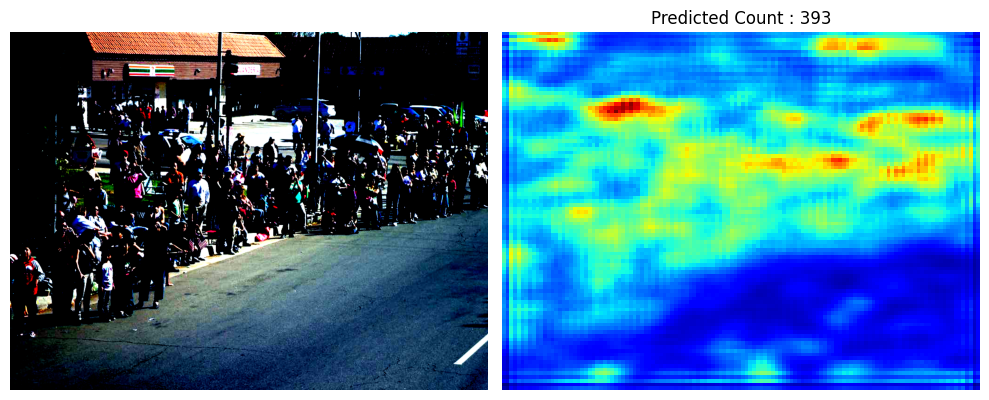

In [15]:
output = model(img[None])
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img.detach().cpu().permute(1, 2, 0))
axes[1].imshow(temp,cmap = c.jet)
axes[1].set_title(f"Predicted Count : {int(output.detach().cpu().sum().numpy())}")
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

---